In [1]:
################################################################################
#                           1 Import packages                                  #
################################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim

# Use a double ended queue (deque) for memory
# When memory is full, this will replace the oldest value with the new one
from collections import deque

# Supress all warnings (e.g. deprecation warnings) for regular use
import warnings
warnings.filterwarnings("ignore")

In [2]:
################################################################################
#                           2 Define model parameters                          #
################################################################################

# Set whether to display on screen (slows model)
DISPLAY_ON_SCREEN = False
# Discount rate of future rewards
GAMMA = 0.95
# Learing rate for neural network
LEARNING_RATE = 0.0003
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 1500000
# Sample batch size for policy network update
BATCH_SIZE = 3

# Number of game steps to play before starting training (all random actions)
REPLAY_START_SIZE = 5000
#REPLAY_START_SIZE = 365 * 5

# Time step between actions
TIME_STEP = 1
# Number of steps between policy -> target network update
SYNC_TARGET_STEPS = 365
# Exploration rate (episolon) is probability of choosing a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.999

# Simulation duration
SIM_DURATION = 365
# Training episodes
TRAINING_EPISODES = 10

In [3]:
################################################################################
#                 3 Define DQN (Duelling Deep Q Network) class                 #
#                    (Used for both policy and target nets)                    #
################################################################################

class DQN(nn.Module):

    """Deep Q Network. Udes for both policy (action) and target (Q) networks."""

    def __init__(self, observation_space, action_space, neurons_per_layer=48):
        """Constructor method. Set up neural nets."""

        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX
        
        # Set up action space (choice of possible actions)
        self.action_space = action_space
              
        
        # First layerswill be common to both Advantage and value
        super(DQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(observation_space, neurons_per_layer),
            nn.ReLU()            
            )
        
        # Advantage has same number of outputs as the action space
        self.advantage = nn.Sequential(
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, action_space)
            )
        
        # State value has only one output (one value per state)
        self.value = nn.Sequential(
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, 1)
            )        
        
    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
            
        else:
            # Otherwise get predicted Q values of actions
            q_values = self.forward(torch.FloatTensor(state))
            # Get index of action with best Q
            action = np.argmax(q_values.detach().numpy()[0])
        
        return  action
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value = self.value(x)
        action_q = value + advantage - advantage.mean()
        return action_q


################################################################################
#                    4 Define policy net training function                     #
################################################################################

def optimize(policy_net, target_net, memory):
    """
    Update  model by sampling from memory.
    Uses policy network to predict best action (best Q).
    Uses target network to provide target of Q for the selected next action.
    """
      
    # Do not try to train model if memory is less than reqired batch size
    if len(memory) < BATCH_SIZE:
        return    
 
    # Reduce exploration rate (exploration rate is stored in policy net)
    policy_net.exploration_rate *= EXPLORATION_DECAY
    policy_net.exploration_rate = max(EXPLORATION_MIN, 
                                      policy_net.exploration_rate)
    # Sample a random batch from memory
    batch = memory.sample(BATCH_SIZE)

    for state, action, reward, state_next, terminal, index in batch:
        
        state_action_values = policy_net(torch.FloatTensor(state))
        
        # Get target Q for policy net update
       
        if not terminal:
            # For non-terminal actions get Q from policy net
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach next state values from gradients to prevent updates
            expected_state_action_values = expected_state_action_values.detach()
            # Get next state action with best Q from the policy net (double DQN)
            policy_next_state_values = policy_net(torch.FloatTensor(state_next))
            policy_next_state_values = policy_next_state_values.detach()
            best_action = np.argmax(policy_next_state_values[0].numpy())
            # Get target net next state
            next_state_action_values = target_net(torch.FloatTensor(state_next))
            # Use detach again to prevent target net gradients being updated
            next_state_action_values = next_state_action_values.detach()
            best_next_q = next_state_action_values[0][best_action].numpy()
            updated_q = reward + (GAMMA * best_next_q)      
            expected_state_action_values[0][action] = updated_q
        else:
            # For termal actions Q = reward (-1)
            expected_state_action_values = policy_net(torch.FloatTensor(state))
            # Detach values from gradients to prevent gradient update
            expected_state_action_values = expected_state_action_values.detach()
            # Set Q for all actions to reward (-1)
            expected_state_action_values[0] = reward
 
        # Set net to training mode
        policy_net.train()
        # Reset net gradients
        policy_net.optimizer.zero_grad()  
        # calculate loss
        loss_v = nn.MSELoss()(state_action_values, expected_state_action_values)
        # Backpropogate loss
        loss_v.backward()
        # Update replay buffer (add 1e-5 to loss to avoid zero priority with no
        # chance of being sampled).
        loss_numpy = loss_v.data.numpy()
        memory.update_priorities(index, loss_numpy + 1e-5)
        # Update network gradients
        policy_net.optimizer.step()  

    return

################################################################################
#                  5 Define prioritised replay memory class                    #
################################################################################

class NaivePrioritizedBuffer():
    """
    Based on code from https://github.com/higgsfield/RL-Adventure
    
    Each sample (state, action, reward, next_state, done) has an associated
    priority, which is the loss from training the policy network. The priority
    is used to adjust the frequency of sampling.    
    """
    
    def __init__(self, capacity=MEMORY_SIZE, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def remember(self, state, action, reward, next_state, done):
        """
        Add sample (state, action, reward, next_state, done) to memory, or
        replace oldest sample if memory full"""

        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            # Add new sample when room in memory
            self.buffer.append((state, action, reward, next_state, done))
        else:
            # Replace sample when memory full
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        # Set maximum priority present
        self.priorities[self.pos] = max_prio
        # Increment replacement position
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        # Get priorities
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        # Raise priorities by the square of 'alpha' 
        # (lower alpha compresses differences)
        probs  = prios ** self.prob_alpha
        
        # Normlaise priorities
        probs /= probs.sum()
        
        # Sample using priorities for relative sampling frequency
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        # Add index to sample (used to update priority after getting new loss)
        batch = []        
        for index, sample in enumerate(samples):
            sample = list(sample)
            sample.append(indices[index])
            batch.append(sample)
        
        return batch
    
    def update_priorities(self, index, priority):
        """Update sample priority with new loss"""
        self.priorities[index] = priority

    def __len__(self):
        return len(self.buffer)

################################################################################
#                       6  Define results plotting function                    #
################################################################################

def plot_results(run, exploration, score, run_details):
    """Plot and report results at end of run"""
    
    # Get beds and patirents from run_detals DataFrame
    next_maint = run_details['next_maint']
    conv_wear = run_details['conv_wear']
    #last_fail = run_details['last_fail']
    
    # Set up chart (ax1 and ax2 share x-axis to combine two plots on one graph)
    fig = plt.figure(figsize=(9,5))
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()
    
    # Plot results
    average_rewards = np.array(score)/SIM_DURATION
    ax1.plot(run, exploration, label='exploration', color='g')
    ax2.plot(run, average_rewards, label='average reward', color='r')
    
    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('exploration', color='g')
    ax2.set_ylabel('average reward', color='r')
    
    # Show last run tracker of beds and patients

    ax3 = fig.add_subplot(122)
    day = np.arange(len(next_maint))*TIME_STEP
    ax3.plot(day, next_maint, label='next_maint', color='g')
    ax3.plot(day, conv_wear, label='conv_wear', color='r')
    #ax3.plot(day, last_fail, label='last_fail', color='b')
    
    # Set axes
    ax3.set_xlabel('run')
    ax3.set_ylabel('main/wear')
    ax3.set_ylim(0)
    ax3.legend()
    ax3.grid()
    # Show
    
    plt.tight_layout(pad=2)
    plt.show()
    
    # Calculate summary results
    # results = pd.Series()
    # beds = np.array(beds)
    # patients = np.array(patients)
    # results['days under capacity'] = np.sum(patients > beds)
    # results['days over capacity'] = np.sum(beds > patients)
    # results['average patients'] = np.round(np.mean(patients), 0)
    # results['average beds'] = np.round(np.mean(beds), 0)
    # results['% occupancy'] = np.round((patients.sum() / beds.sum() * 100), 1)
    # print (results);

In [4]:
################################################################################
#                                 7 Main program                               #
################################################################################

def pr_ddqn_sim():
    """Main program loop"""
    
    ############################################################################
    #                          8 Set up environment                            #
    ############################################################################
    from modules.process.production_line import ProductionLine    
    # Set up game environemnt
    #sim = HospGym(sim_duration=SIM_DURATION, time_step=TIME_STEP)
    p_d = ProductionLine(debug=False)

    # Get number of observations returned for state
    p_d.reset()
    observation_space = p_d.observation_size
    
    # Get number of actions possible
    action_space = p_d.action_size
    
    ############################################################################
    #                    9 Set up policy and target nets                       #
    ############################################################################
    
    # Set up policy and target neural nets
    policy_net = DQN(observation_space, action_space)
    target_net = DQN(observation_space, action_space)
    
    # Set loss function and optimizer
    policy_net.optimizer = optim.Adam(
            params=policy_net.parameters(), lr=LEARNING_RATE)
    
    # Copy weights from policy_net to target
    target_net.load_state_dict(policy_net.state_dict())
    
    # Set target net to eval rather than training mode
    # We do not train target net - ot is copied from policy net at intervals
    target_net.eval()
    
    ############################################################################
    #                            10 Set up memory                              #
    ############################################################################
        
    # Set up memomry
    memory = NaivePrioritizedBuffer()
    
    ############################################################################
    #                     11 Set up + start training loop                      #
    ############################################################################
    
    # Set up run counter and learning loop    
    run = 0
    all_steps = 0
    continue_learning = True
    
    # Set up list for results
    results_run = []
    results_exploration = []
    results_score = []
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        ########################################################################
        #                           12 Play episode                            #
        ########################################################################
        
        # Increment run (episode) counter
        run += 1
        
        ########################################################################
        #                             13 Reset game                            #
        ########################################################################
        
        # Reset environment and get first state observations
        state = p_d.reset()
        
        # Trackers for state
        time = []
        line_state = []
        next_maint = []
        conv_state = []
        conv_wear = []
        #last_fail = []
        rewards = []
        
        # Reset total reward
        total_reward = 0
        
        # Reshape state into 2D array with state observations as first 'row'
        state = np.reshape(state, [1, observation_space])
              
        # Continue loop until episode complete
        while True:
            
        ########################################################################
        #                       14 Game episode loop                           #
        ########################################################################
            
            ####################################################################
            #                       15 Get action                              #
            ####################################################################
            
            # Get action to take (se eval mode to avoid dropout layers)
            policy_net.eval()
            action = policy_net.act(state)
            
            ####################################################################
            #                 16 Play action (get S', R, T)                    #
            ####################################################################
            
            # Act 
            state_next, reward, terminal = p_d.step(action)
            total_reward += reward

            # Update trackers
            time.append(state_next[1])
            line_state.append(state_next[0])
            next_maint.append(state_next[4])
            conv_state.append(state_next[5])
            conv_wear.append([v for k,v in p_d.get_resource_states()['hidden states'].items()][0])
            #last_fail.append(p_d.last_fail)
            rewards.append(reward)
                                                          
            # Reshape state into 2D array with state obsverations as first 'row'
            state_next = np.reshape(state_next, [1, observation_space])
            
            # Update display if needed
            if DISPLAY_ON_SCREEN:
                p_d.render()
            
            ####################################################################
            #                  17 Add S/A/R/S/T to memory                      #
            ####################################################################
            
            # Record state, action, reward, new state & terminal
            memory.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            ####################################################################
            #                  18 Check for end of episode                     #
            ####################################################################
            
            # Actions to take if end of game episode
            if terminal:
                print('TERMINAL STATE')
                # Get exploration rate
                exploration = policy_net.exploration_rate
                # Clear print row content
                clear_row = '\r' + ' '*79 + '\r'
                print(clear_row, end='')
                print(f'Episode: {run}, ', end='')
                print(f'Exploration: {exploration: .3f}, ', end='')
                average_reward = total_reward/p_d.step_no
                print(f'Average reward: {average_reward:4.1f}, ', end='')
                print(f'Total reward: {total_reward:4.1f}, ', end='')
                print(f'Steps: {p_d.step_no}, ', end='')
                print(f'Processes: {p_d.process_no}, ', end='')
                print(f'Env time: {p_d.env.now}', end='')
                print('')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(exploration)
                results_score.append(total_reward)
                
                ################################################################
                #             18b Check for end of learning                    #
                ################################################################
                
                if run == TRAINING_EPISODES:
                    continue_learning = False
                
                # End episode loop
                break
            
            
            ####################################################################
            #                        19 Update policy net                      #
            ####################################################################
            
            # Avoid training model if memory is not of sufficient length
            if len(memory) > REPLAY_START_SIZE:
        
                # Update policy net
                optimize(policy_net, target_net, memory)

                ################################################################
                #             20 Update target net periodically                #
                ################################################################
                
                # Use load_state_dict method to copy weights from policy net
                if all_steps % SYNC_TARGET_STEPS == 0:
                    target_net.load_state_dict(policy_net.state_dict())
                
    ############################################################################
    #                      21 Learning complete - plot results                 #
    ############################################################################
    
    # Add last run to DataFrame. summarise, and return
    run_details = pd.DataFrame()
    run_details['time'] = time 
    run_details['line_state'] = line_state
    run_details['next_maint'] = next_maint
    run_details['conv_state'] = conv_state
    run_details['conv_wear'] = conv_wear
    #run_details['last_fail'] = last_fail
    run_details['reward'] = rewards
        
    # Target reached. Plot results
    plot_results(results_run, results_exploration, results_score, run_details)
    
    return run_details

TERMINAL STATE
Episode: 1, Exploration:  1.000, Average reward: -252.6, Total reward: -1131524.0, Steps: 4479, Processes: 372, Env time: 14402
TERMINAL STATE
Episode: 2, Exploration:  0.010, Average reward: -16.2, Total reward: -84220.0, Steps: 5211, Processes: 400, Env time: 15222
TERMINAL STATE
Episode: 3, Exploration:  0.010, Average reward: -0.8, Total reward: -3647.0, Steps: 4676, Processes: 388, Env time: 14844
TERMINAL STATE
Episode: 4, Exploration:  0.010, Average reward: -1.5, Total reward: -7306.0, Steps: 5011, Processes: 414, Env time: 14407
TERMINAL STATE
Episode: 5, Exploration:  0.010, Average reward: -27.8, Total reward: -138223.0, Steps: 4974, Processes: 413, Env time: 14410
TERMINAL STATE
Episode: 6, Exploration:  0.010, Average reward: -2.3, Total reward: -13969.0, Steps: 6056, Processes: 497, Env time: 14402
TERMINAL STATE
Episode: 7, Exploration:  0.010, Average reward: -3.3, Total reward: -20107.0, Steps: 6026, Processes: 495, Env time: 14406
TERMINAL STATE
Episode

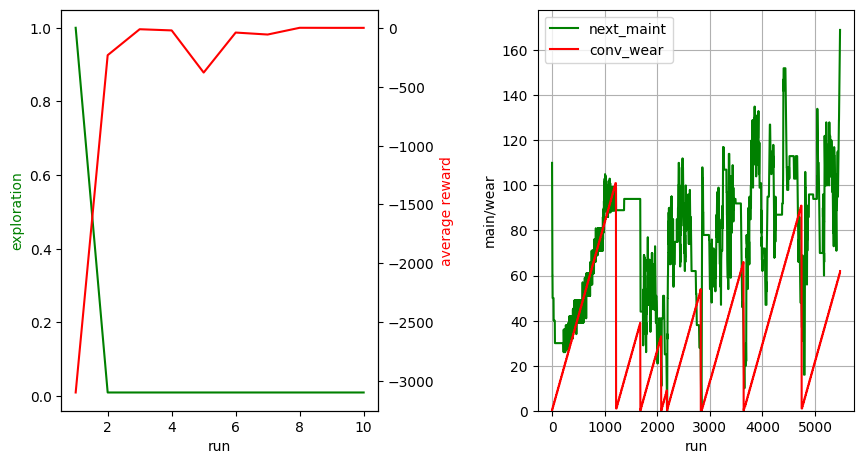

In [5]:
# Run model and return last run results by day
last_run = pr_ddqn_sim()

In [6]:
last_run

,time,line_state,next_maint,conv_state,conv_wear,reward
0,0,1,110,0,0,1
1,0,1,100,1,0,1
2,0,1,90,1,0,1
3,0,1,80,1,1,1
4,0,1,70,1,1,1
...,...,...,...,...,...,...
5473,239,1,161,1,61,1
5474,239,1,163,1,61,1
5475,239,1,165,1,61,1
5476,239,1,167,1,61,1


In [7]:
print(f'Steps: {4}')

Steps: 4
